In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
import sys

In [ ]:
pwd

In [2]:
cd /kaggle/input/function-vectors

/kaggle/input/function-vectors


In [ ]:
!pip install bitsandbytes
!pip install git+https://github.com/davidbau/baukit

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

In [3]:
import os, re, json
import torch, numpy as np

import sys
sys.path.append('..')
torch.set_grad_enabled(False)

from src.utils.extract_utils import get_mean_head_activations, compute_universal_function_vector
from src.utils.intervention_utils import fv_intervention_natural_text, function_vector_intervention
from src.utils.model_utils import load_gpt_model_and_tokenizer
from src.utils.prompt_utils import load_dataset, word_pairs_to_prompt_data, create_prompt
from src.utils.eval_utils import decode_to_vocab, sentence_eval

/usr/local/lib/python3.8/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/usr/local/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
model_name = 'EleutherAI/gpt-j-6b'
model_name = 'daryl149/llama-2-7b-chat-hf'
model, tokenizer, model_config = load_gpt_model_and_tokenizer(model_name, 'cpu')
EDIT_LAYER = 9

Loading:  daryl149/llama-2-7b-chat-hf


Loading checkpoint shards: 100%|██████████| 2/2 [00:12<00:00,  6.40s/it]


In [21]:
!ls dataset_files/

README.md  abstractive	extractive  generate


In [23]:
!mkdir notebooks

mkdir: cannot create directory ‘notebooks’: File exists


In [27]:
%cd notebooks

/kaggle/input/function-vectors/notebooks


In [29]:
dataset = load_dataset('antonym', seed=0) #, root_data_dir='dataset_files/'
mean_activations = get_mean_head_activations(dataset, model, model_config, tokenizer)

In [99]:
dataset['train'][1000]

{'input': 'bump', 'output': 'smooth'}

In [101]:
mean_activations.shape

torch.Size([32, 32, 97, 128])

In [36]:
model_config['name_or_path'] = 'Llama-2-7b-llama'

In [37]:
FV, top_heads = compute_universal_function_vector(mean_activations, model, model_config, n_top_heads=10)

In [93]:
FV.shape

torch.Size([1, 4096])

In [41]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNo

In [40]:
top_heads

[(14, 1, 0.0391),
 (11, 2, 0.0225),
 (9, 25, 0.02),
 (12, 15, 0.0196),
 (12, 28, 0.0191),
 (13, 7, 0.0171),
 (11, 18, 0.0152),
 (12, 18, 0.0113),
 (16, 10, 0.007),
 (14, 16, 0.007)]

In [42]:
from src.utils.extract_utils import *

In [43]:
def compute_universal_function_vector_berke(mean_activations, model, model_config, n_top_heads=10, T=-1):
    model_resid_dim = model_config['resid_dim']
    model_n_heads = model_config['n_heads']
    model_head_dim = model_resid_dim // model_n_heads
    device = model.device

    # Universal Set of Heads
    
    if 'gpt-j' in model_config['name_or_path']:
        top_heads = [(15, 5, 0.0587), (9, 14, 0.0584), (12, 10, 0.0526), (8, 1, 0.0445), (11, 0, 0.0445), (13, 13, 0.019), (8, 0, 0.0184), (14, 9, 0.016), (9, 2, 0.0127), (24, 6, 0.0113), (15, 11, 0.0092),
                     (6, 6, 0.0069), (14, 0, 0.0068), (17, 8, 0.0068), (21, 2, 0.0067), (10, 11, 0.0066), (11, 2, 0.0057), (17, 0, 0.0054), (20, 11, 0.0051), (23, 0, 0.0047), (20, 0, 0.0046), (15, 7, 0.0045),
                     (27, 2, 0.0045), (21, 15, 0.0044), (11, 4, 0.0044), (18, 6, 0.0043), (9, 6, 0.0042), (4, 12, 0.004), (11, 15, 0.004), (20, 2, 0.0036), (10, 0, 0.0035), (16, 9, 0.0031), (11, 14, 0.0031),
                     (12, 4, 0.003), (9, 7, 0.003), (18, 3, 0.003), (19, 5, 0.003), (22, 5, 0.0027), (25, 3, 0.0026), (18, 9, 0.0025)]
    elif 'Llama-2-7b' in model_config['name_or_path']:
        top_heads = [(14, 1, 0.0391), (11, 2, 0.0225), (9, 25, 0.02), (12, 15, 0.0196), (12, 28, 0.0191), (13, 7, 0.0171), (11, 18, 0.0152), (12, 18, 0.0113), (16, 10, 0.007), (14, 16, 0.007),
                     (14, 14, 0.0048), (16, 1, 0.0042), (18, 1, 0.0042), (19, 16, 0.0041), (13, 30, 0.0034), (18, 26, 0.0032), (14, 7, 0.0032), (16, 0, 0.0031), (16, 29, 0.003), (29, 30, 0.003),
                     (16, 6, 0.0029), (15, 11, 0.0027), (12, 11, 0.0026), (11, 22, 0.0023), (16, 19, 0.0021), (15, 23, 0.002), (16, 20, 0.0019), (15, 9, 0.0019), (17, 28, 0.0019), (14, 18, 0.0018),
                     (8, 26, 0.0018), (29, 26, 0.0018), (15, 8, 0.0018), (13, 13, 0.0017), (30, 9, 0.0017), (13, 23, 0.0017), (13, 10, 0.0016), (11, 30, 0.0016), (12, 26, 0.0015), (19, 27, 0.0015),
                     (14, 9, 0.0014), (14, 10, 0.0013), (31, 17, 0.0013), (31, 4, 0.0013), (15, 17, 0.0013), (10, 5, 0.0012), (14, 11, 0.0012), (19, 12, 0.0012), (16, 7, 0.0012), (15, 24, 0.0011),
                     (26, 28, 0.0011), (11, 15, 0.0011), (15, 25, 0.0011), (17, 12, 0.0011), (13, 2, 0.0011), (14, 5, 0.0011), (14, 3, 0.001), (26, 30, 0.001), (27, 29, 0.001), (25, 12, 0.0009),
                     (15, 13, 0.0009), (10, 14, 0.0009), (28, 13, 0.0009), (17, 19, 0.0008), (19, 2, 0.0008), (12, 23, 0.0008), (15, 26, 0.0008), (28, 21, 0.0008), (15, 10, 0.0008), (12, 0, 0.0007),
                     (6, 16, 0.0007), (7, 28, 0.0007), (27, 7, 0.0007), (11, 28, 0.0007), (29, 15, 0.0006), (13, 8, 0.0006), (13, 17, 0.0006), (8, 0, 0.0006), (22, 17, 0.0006), (22, 20, 0.0006), 
                     (12, 2, 0.0006), (26, 9, 0.0006), (31, 26, 0.0006), (22, 27, 0.0005), (16, 26, 0.0005), (13, 1, 0.0005), (26, 2, 0.0005), (30, 10, 0.0005), (11, 25, 0.0005), (29, 20, 0.0005),
                     (19, 15, 0.0005), (12, 10, 0.0005), (12, 3, 0.0005), (30, 5, 0.0004), (6, 9, 0.0004), (15, 16, 0.0004), (23, 28, 0.0004), (22, 5, 0.0004), (31, 19, 0.0004), (26, 14, 0.0004)]
    elif 'Llama-2-13b' in model_config['name_or_path']:
        top_heads = [(13, 13, 0.0402), (12, 17, 0.0332), (15, 38, 0.0269), (14, 34, 0.0209), (19, 2, 0.0116), (19, 36, 0.0106), (13, 4, 0.0106), (18, 11, 0.01), (10, 15, 0.0087), (13, 23, 0.0077),
                     (14, 7, 0.0074), (15, 36, 0.0046), (12, 8, 0.0046), (17, 7, 0.0044), (38, 29, 0.0043), (15, 32, 0.0037), (17, 18, 0.0034), (16, 9, 0.0033), (14, 23, 0.0032), (39, 13, 0.0029),
                     (39, 14, 0.0027), (18, 22, 0.0026), (21, 32, 0.0026), (15, 18, 0.0026), (13, 14, 0.0026), (11, 31, 0.0025), (14, 39, 0.0024), (19, 14, 0.0023), (36, 23, 0.0021), (21, 7, 0.0021),
                     (8, 23, 0.002), (18, 18, 0.002), (17, 28, 0.002), (17, 9, 0.0019), (13, 27, 0.0017), (13, 34, 0.0017), (13, 12, 0.0016), (21, 2, 0.0016), (16, 16, 0.0015), (15, 31, 0.0015),
                     (26, 35, 0.0015), (10, 18, 0.0014), (11, 27, 0.0014), (13, 25, 0.0014), (15, 26, 0.0013), (5, 32, 0.0013), (20, 12, 0.0013), (18, 15, 0.0013), (16, 23, 0.0013), (25, 5, 0.0013),
                     (34, 6, 0.0012), (15, 2, 0.0012), (15, 27, 0.0012), (18, 20, 0.0012), (16, 19, 0.0011), (37, 4, 0.001), (19, 7, 0.001), (19, 3, 0.0009), (38, 14, 0.0009), (20, 21, 0.0009),
                     (21, 30, 0.0009), (16, 11, 0.0009), (13, 24, 0.0009), (9, 31, 0.0008), (14, 13, 0.0008), (16, 29, 0.0008), (15, 17, 0.0008), (19, 6, 0.0008), (23, 36, 0.0008), (18, 17, 0.0007),
                     (15, 34, 0.0007), (14, 29, 0.0007), (15, 7, 0.0007), (13, 17, 0.0007), (20, 11, 0.0007), (35, 16, 0.0007), (39, 27, 0.0007), (29, 27, 0.0006), (30, 24, 0.0006), (19, 37, 0.0006),
                     (39, 21, 0.0006), (13, 36, 0.0006), (37, 30, 0.0006), (16, 36, 0.0006), (15, 3, 0.0006), (19, 13, 0.0006), (13, 10, 0.0006), (14, 19, 0.0005), (36, 3, 0.0005), (15, 25, 0.0005),
                     (16, 0, 0.0005), (16, 10, 0.0005), (20, 29, 0.0005), (25, 13, 0.0005), (14, 36, 0.0005), (36, 7, 0.0005), (17, 0, 0.0005), (11, 37, 0.0005), (23, 18, 0.0005), (35, 10, 0.0005)]
    elif 'Llama-2-70b' in model_config['name_or_path']:
        top_heads = [(33, 63, 0.0315), (36, 3, 0.0313), (29, 7, 0.0193), (40, 50, 0.0147), (26, 57, 0.0136), (40, 57, 0.0134), (40, 54, 0.0127), (36, 0, 0.011), (29, 3, 0.0109), (39, 61, 0.0085),
                     (77, 8, 0.0082), (14, 29, 0.0079), (39, 26, 0.0074), (37, 17, 0.0069), (40, 55, 0.0066), (34, 40, 0.0064), (39, 56, 0.0063), (34, 41, 0.0061), (36, 54, 0.0058), (29, 1, 0.0058),
                     (38, 20, 0.0053), (40, 48, 0.0051), (39, 30, 0.005), (34, 60, 0.0048), (34, 42, 0.0045), (26, 62, 0.0044), (77, 15, 0.0044), (77, 14, 0.0042), (43, 63, 0.0041), (31, 27, 0.004),
                     (31, 20, 0.004), (40, 6, 0.0038), (44, 63, 0.0036), (36, 41, 0.0034), (79, 34, 0.0033), (46, 31, 0.0033), (29, 4, 0.0033), (39, 36, 0.0032), (42, 10, 0.0031), (14, 30, 0.003),
                     (26, 25, 0.0029), (40, 61, 0.0028), (40, 39, 0.0028), (34, 25, 0.0028), (39, 59, 0.0027), (34, 56, 0.0025), (26, 31, 0.0025), (43, 4, 0.0025), (11, 21, 0.0024), (47, 44, 0.0023),
                     (76, 44, 0.0022), (38, 18, 0.0022), (75, 62, 0.0022), (21, 32, 0.0021), (51, 41, 0.002), (36, 32, 0.002), (44, 59, 0.0019), (43, 27, 0.0019), (40, 51, 0.0019), (32, 3, 0.0019),
                     (38, 11, 0.0018), (32, 11, 0.0018), (35, 2, 0.0018), (25, 13, 0.0018), (42, 12, 0.0017), (25, 3, 0.0017), (24, 0, 0.0017), (38, 3, 0.0017), (34, 46, 0.0016), (31, 5, 0.0016),
                     (38, 55, 0.0016), (40, 21, 0.0016), (40, 33, 0.0016), (77, 25, 0.0015), (42, 18, 0.0015), (35, 34, 0.0015), (7, 63, 0.0014), (24, 45, 0.0014), (39, 34, 0.0014), (27, 35, 0.0014),
                     (38, 34, 0.0014), (38, 19, 0.0013), (41, 33, 0.0013), (18, 61, 0.0013), (22, 36, 0.0013), (38, 51, 0.0013), (25, 7, 0.0013), (29, 17, 0.0012), (28, 45, 0.0012), (35, 8, 0.0012),
                     (69, 17, 0.0012), (72, 26, 0.0012), (44, 18, 0.0012), (43, 7, 0.0012), (76, 34, 0.0011), (10, 62, 0.0011), (14, 31, 0.0011), (45, 57, 0.0011), (25, 14, 0.0011), (30, 15, 0.0011),
                     (47, 1, 0.0011), (15, 46, 0.0011), (27, 57, 0.001), (37, 37, 0.001), (30, 9, 0.001), (16, 28, 0.001), (28, 7, 0.001), (29, 18, 0.001), (35, 5, 0.001), (14, 28, 0.001), (72, 24, 0.001),
                     (37, 10, 0.001), (26, 63, 0.001), (72, 29, 0.001), (39, 13, 0.001), (77, 59, 0.0009), (76, 36, 0.0009), (23, 59, 0.0009), (39, 35, 0.0009), (43, 16, 0.0009), (33, 49, 0.0009),
                     (33, 31, 0.0009), (29, 19, 0.0009), (43, 2, 0.0009), (40, 45, 0.0009), (76, 50, 0.0009), (38, 35, 0.0009), (39, 28, 0.0009), (20, 4, 0.0009), (36, 2, 0.0008), (38, 12, 0.0008),
                     (20, 47, 0.0008), (78, 44, 0.0008), (39, 57, 0.0008), (30, 26, 0.0008), (63, 52, 0.0008), (7, 62, 0.0008), (30, 6, 0.0008), (25, 10, 0.0008), (76, 32, 0.0008), (36, 45, 0.0008),
                     (27, 44, 0.0008), (38, 58, 0.0008), (38, 6, 0.0008), (36, 46, 0.0008), (31, 21, 0.0008), (22, 38, 0.0007), (36, 44, 0.0007), (71, 61, 0.0007), (37, 15, 0.0007), (39, 31, 0.0007),
                     (27, 48, 0.0007), (24, 41, 0.0007), (43, 49, 0.0007), (40, 26, 0.0007), (13, 31, 0.0007), (21, 34, 0.0007), (26, 61, 0.0007), (36, 11, 0.0007), (28, 34, 0.0007), (22, 18, 0.0007),
                     (34, 3, 0.0007), (40, 52, 0.0007), (32, 37, 0.0006), (76, 13, 0.0006), (74, 58, 0.0006), (43, 24, 0.0006), (17, 2, 0.0006), (21, 4, 0.0006), (59, 50, 0.0006), (37, 44, 0.0006),
                     (27, 46, 0.0006), (69, 28, 0.0006), (29, 11, 0.0006), (31, 25, 0.0006), (20, 18, 0.0006), (40, 63, 0.0006), (37, 19, 0.0006), (36, 23, 0.0006), (34, 13, 0.0006), (69, 19, 0.0006),
                     (44, 17, 0.0006), (44, 32, 0.0005), (26, 23, 0.0005), (42, 13, 0.0005), (34, 18, 0.0005), (75, 56, 0.0005), (37, 14, 0.0005), (25, 50, 0.0005), (42, 61, 0.0005), (43, 1, 0.0005),
                     (77, 27, 0.0005), (40, 24, 0.0005), (63, 50, 0.0005), (24, 25, 0.0005), (43, 30, 0.0005), (79, 23, 0.0005), (38, 62, 0.0005), (23, 9, 0.0005), (35, 30, 0.0005), (32, 34, 0.0005),
                     (39, 60, 0.0005), (29, 63, 0.0005), (55, 8, 0.0005), (6, 12, 0.0005), (39, 47, 0.0005), (44, 14, 0.0005), (36, 47, 0.0005), (6, 34, 0.0005), (41, 8, 0.0005), (36, 1, 0.0005),
                     (30, 22, 0.0005), (52, 20, 0.0005), (52, 56, 0.0004), (64, 23, 0.0004), (74, 5, 0.0004), (41, 63, 0.0004), (67, 23, 0.0004), (17, 23, 0.0004), (49, 23, 0.0004), (76, 39, 0.0004),
                     (49, 59, 0.0004), (18, 30, 0.0004), (37, 8, 0.0004), (23, 27, 0.0004), (36, 43, 0.0004), (57, 3, 0.0004), (39, 37, 0.0004), (37, 61, 0.0004), (39, 25, 0.0004), (25, 25, 0.0004),
                     (23, 38, 0.0004), (38, 49, 0.0004), (35, 27, 0.0004), (32, 9, 0.0004), (69, 30, 0.0004), (25, 9, 0.0004), (39, 32, 0.0004), (34, 57, 0.0004), (40, 47, 0.0004), (19, 51, 0.0004),
                     (16, 0, 0.0004), (20, 19, 0.0004), (44, 57, 0.0004), (40, 34, 0.0004), (79, 25, 0.0004), (69, 27, 0.0004), (76, 26, 0.0004), (26, 30, 0.0004), (72, 31, 0.0004), (26, 29, 0.0004),
                     (55, 15, 0.0004), (33, 58, 0.0004), (18, 25, 0.0004), (25, 2, 0.0004), (33, 27, 0.0004), (20, 40, 0.0004), (24, 27, 0.0004), (17, 3, 0.0004), (18, 62, 0.0004), (47, 7, 0.0004),
                     (33, 28, 0.0004), (31, 11, 0.0004), (24, 28, 0.0004), (37, 7, 0.0004), (40, 7, 0.0004), (32, 61, 0.0004)]
    elif 'gpt-neox' in model_config['name_or_path']:
        top_heads = [(9, 42, 0.0293), (12, 4, 0.0224), (9, 28, 0.019), (11, 57, 0.0079), (10, 43, 0.0073), (12, 14, 0.0069), (14, 31, 0.0065), (9, 23, 0.0057), (11, 21, 0.0054), (11, 4, 0.0052),
                     (9, 21, 0.0052), (18, 23, 0.005), (13, 9, 0.0048), (14, 49, 0.0048), (12, 20, 0.0047), (8, 30, 0.0045), (12, 59, 0.0043), (16, 42, 0.0039), (11, 34, 0.0038), (9, 33, 0.0038),
                     (9, 3, 0.0036), (11, 48, 0.0035), (14, 63, 0.0032), (18, 11, 0.0032), (13, 7, 0.003), (9, 27, 0.0029), (11, 23, 0.0029), (16, 30, 0.0027), (10, 17, 0.0026), (9, 55, 0.0024),
                     (11, 38, 0.0024), (11, 59, 0.0024), (20, 8, 0.0024), (15, 42, 0.0023), (11, 47, 0.0023), (9, 15, 0.0023), (8, 47, 0.0023), (10, 40, 0.0023), (18, 18, 0.0022), (9, 1, 0.0021),
                     (13, 12, 0.0021), (14, 5, 0.002), (16, 18, 0.0019), (13, 63, 0.0019), (9, 20, 0.0018), (26, 38, 0.0018), (21, 60, 0.0017), (17, 55, 0.0016), (17, 30, 0.0016), (10, 56, 0.0015),
                     (12, 3, 0.0015), (10, 16, 0.0014), (10, 0, 0.0013), (15, 62, 0.0013), (12, 15, 0.0013), (9, 34, 0.0013), (12, 18, 0.0013), (23, 46, 0.0012), (16, 53, 0.0012), (11, 1, 0.0011),
                     (9, 2, 0.0011), (10, 27, 0.0011), (23, 54, 0.0011), (16, 54, 0.0011), (12, 30, 0.0011), (11, 14, 0.0011), (16, 44, 0.001), (14, 27, 0.001), (26, 31, 0.001), (15, 0, 0.001),
                     (13, 46, 0.001), (15, 57, 0.001), (15, 17, 0.001), (19, 12, 0.0009), (9, 49, 0.0009), (10, 7, 0.0009), (19, 46, 0.0009), (8, 21, 0.0009), (25, 24, 0.0008), (19, 29, 0.0008),
                     (12, 21, 0.0008), (8, 18, 0.0008), (12, 35, 0.0008), (9, 10, 0.0008), (19, 40, 0.0008), (38, 5, 0.0008), (13, 31, 0.0007), (10, 38, 0.0007), (10, 12, 0.0007), (11, 31, 0.0007),
                     (10, 1, 0.0007), (23, 15, 0.0007), (13, 40, 0.0007), (9, 5, 0.0007), (22, 33, 0.0007), (13, 36, 0.0006), (8, 32, 0.0006), (16, 21, 0.0006), (14, 11, 0.0006), (13, 61, 0.0006)]
    
    top_heads = top_heads[:n_top_heads]

    # Compute Function Vector as sum of influential heads
    function_vector = torch.zeros((1,1,model_resid_dim)).to(device)

    for L,H,_ in top_heads:
        if 'gpt2-xl' in model_config['name_or_path']:
            out_proj = model.transformer.h[L].attn.c_proj
        elif 'gpt-j' in model_config['name_or_path']:
            out_proj = model.transformer.h[L].attn.out_proj
        elif 'llama' in model_config['name_or_path'].lower():
            out_proj = model.model.layers[L].self_attn.o_proj
        elif 'gpt-neox' in model_config['name_or_path']:
            out_proj = model.gpt_neox.layers[L].attention.dense

        x = torch.zeros(model_resid_dim)
        x[H*model_head_dim:(H+1)*model_head_dim] = mean_activations[L,H,T]
        d_out = out_proj(x.reshape(1,1,model_resid_dim).to(device).to(model.dtype))

        function_vector += d_out
        function_vector = function_vector.to(model.dtype)
    function_vector = function_vector.reshape(1, model_resid_dim)

    return function_vector, top_heads

In [56]:
FV, top_heads = compute_universal_function_vector_berke(mean_activations, model, model_config, n_top_heads=10, T=-97)

In [57]:
FV_ls = [compute_universal_function_vector_berke(mean_activations, model, model_config, n_top_heads=10, T=-i)[0] for i in range(1, 97)]

In [66]:
tensor_data = [tensor.numpy() for tensor in FV_ls]

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt

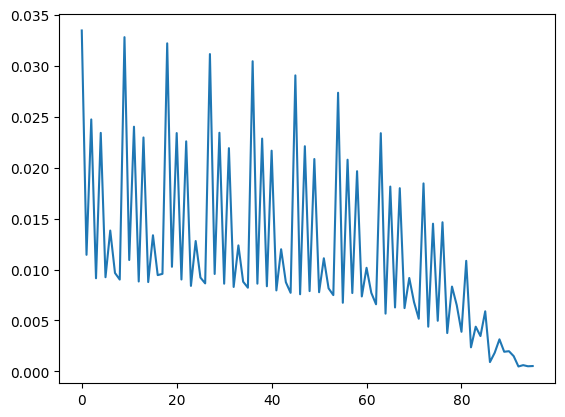

In [91]:
plt.plot(np.var(np.array(tensor_data).squeeze(1), axis=1))

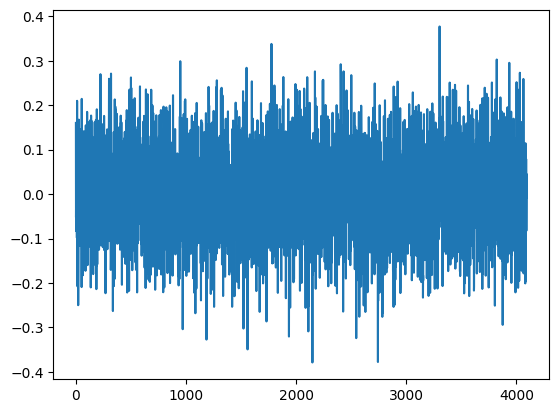

In [77]:
plt.plot(np.array(tensor_data)[60, :][0])

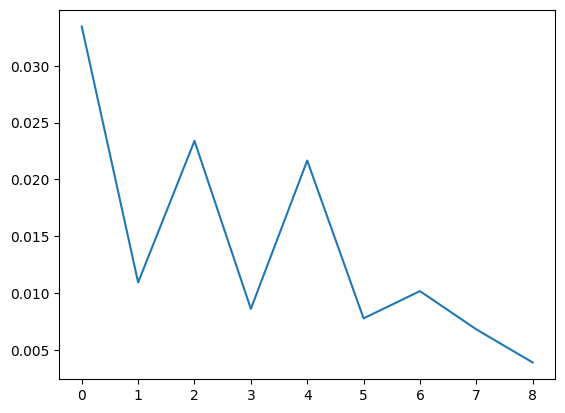

In [81]:
plt.plot([np.var(np.array(tensor_data)[i*10, :][0]) for i in range(0, 9, 1)])

Prompt Creation - ICL, Shuffled-Label, Zero-Shot, and Natural Text

In [ ]:
# Sample ICL example pairs, and a test word
dataset = load_dataset('antonym')
word_pairs = dataset['train'][:5]
test_pair = dataset['test'][21]

prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True)
sentence = create_prompt(prompt_data)
print("ICL prompt:\n", repr(sentence), '\n\n')

shuffled_prompt_data = word_pairs_to_prompt_data(word_pairs, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
shuffled_sentence = create_prompt(shuffled_prompt_data)
print("Shuffled ICL Prompt:\n", repr(shuffled_sentence), '\n\n')

zeroshot_prompt_data = word_pairs_to_prompt_data({'input':[], 'output':[]}, query_target_pair=test_pair, prepend_bos_token=True, shuffle_labels=True)
zeroshot_sentence = create_prompt(zeroshot_prompt_data)
print("Zero-Shot Prompt:\n", repr(zeroshot_sentence))

Clean ICL Prompt

In [ ]:
# Check model's ICL answer
clean_logits = sentence_eval(sentence, [test_pair['output']], model, tokenizer, compute_nll=False)

print("Input Sentence:", repr(sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("ICL Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')

Corrupted ICL Prompt

In [ ]:
# Perform an intervention on the shuffled setting
clean_logits, interv_logits = function_vector_intervention(shuffled_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

print("Input Sentence:", repr(shuffled_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("Few-Shot-Shuffled Prompt Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')
print("Shuffled Prompt+FV Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

Zero-Shot Prompt

In [ ]:
# Intervention on the zero-shot prompt
clean_logits, interv_logits = function_vector_intervention(zeroshot_sentence, [test_pair['output']], EDIT_LAYER, FV, model, model_config, tokenizer)

print("Input Sentence:", repr(zeroshot_sentence), '\n')
print(f"Input Query: {repr(test_pair['input'])}, Target: {repr(test_pair['output'])}\n")
print("Zero-Shot Top K Vocab Probs:\n", decode_to_vocab(clean_logits, tokenizer, k=5), '\n')
print("Zero-Shot+FV Vocab Top K Vocab Probs:\n", decode_to_vocab(interv_logits, tokenizer, k=5))

Natural Text Prompt

In [ ]:
sentence = f"The word \"{test_pair['input']}\" means"
co, io = fv_intervention_natural_text(sentence, EDIT_LAYER, FV, model, model_config, tokenizer, max_new_tokens=10)


print("Input Sentence: ", repr(sentence))
print("GPT-J:" , repr(tokenizer.decode(co.squeeze())))
print("GPT-J+FV:", repr(tokenizer.decode(io.squeeze())), '\n')